In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 14})

# Conn2res
from conn2res.connectivity import Conn
from conn2res import readout

# Expanded Conn2res
import task_class as tc
import RC_lesion as RC

# Understanding the effects of plasticity and delays on memory capacity

The first objective of this project is to investigate the impacts of plasticity and delays on the memory capacity of the model. For this, we first need to implement the plasticity and delay mechanisms in Conn2res (Suárez <i>et al.</i>, 2024).

## Without delays

### Inspiration of the plasticity rule

The plasticity rule in the expanded Conn2res package is inspired by Falandays <i>et al</i>. (2024). Their full implementation is detailed below, applied to the task of a "little robot" that needs to turn to follow a signal. The signal turns 360 degrees and switches direction after two full rotations.

This plasticity defined by Falandays <i>et al.</i> (2024) uses both internal and synaptic plasticity: the desired activation level of the node is updated and the strength of the connections is updated.

In the updated conn2res package, only internal plasticity is applied.

In [2]:
# The class code is provided in a separate file
import Falandays_plasticity as fp

# Define a randomised connectivity matrix
c = fp.ConnPlasticity(N = 200, rho = 0.9, dist = "normal")

# Define the input and output matrix
w_in = c.get_input_matrix(N = 62, weight = 2)
w_out = c.get_output_matrix(N = 2, weight = 1)

# Define the rotation task
rotation = fp.RotationTask("Rotation", n_trials = 25)
u = rotation.fetch_data()

C:\Users\laura\anaconda3\envs\test2\lib\site-packages\conn2res\connectivity.py:302: UserWarning: Asymmetric connectivity matrix is only weakly checked for connectedness.
  warnings.warn("Asymmetric connectivity matrix is only weakly checked for connectedness.")


In [3]:
# Create a reservoir network
esn = fp.PlasticityReservoir(c.w, c.w_start, w_in, plasticity=True, W_out=w_out)

In [4]:
# Define a function that gets the next input
# The input is dependent on the previous output
def get_input(inp, out):
    eyes_robot = [((out - 31) - 60 + 4 * i)%360 for i in range(31)] + [((out + 30) - 60 + 4 * i)%360 for i in range(31)]
    eyes_robot = np.array(eyes_robot)
    
    distances = np.abs(eyes_robot - inp)
    distance_real = np.where(distances < (360-distances), distances, 360-distances)
    i = np.exp(- distance_real**2 / 10)

    return i

In [5]:
outputs = esn.run_task(U=u, f=get_input, T_min=1, output=90, leaking=.75, lr_W=1, lr_T=0.01, Amp_out=10, task="robot")

C:\Users\laura\conn2res\examples\Falandays_plasticity.py:323: RuntimeWarning: invalid value encountered in divide
  update = update / active_neighbours #element-wise division


In [6]:
outputs = outputs[0]

Now we can visualise how well our robot is able to track the signal.

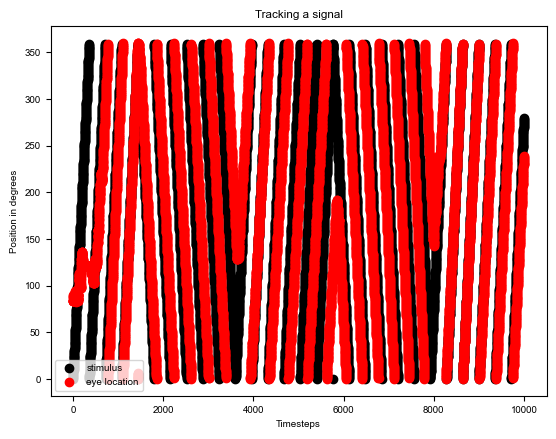

In [7]:
t = np.linspace(0, len(u), len(u))
plt.plot(t[:10000], u[:10000], 'o', label='stimulus', color = 'black')
plt.plot(t[:10000], np.array(outputs)[1:10001], 'o', label='eye location', color = 'red')
plt.xlabel('Timesteps')
plt.ylabel('Position in degrees')
plt.title("Tracking a signal")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.show()

### Robustness to lesions with and without plasticity

We assess the robustness of the model to lesions. Therefore, we incrementally increase the number of lesions in the model. A lesioned node is a node with a constant zero state. This experiment is performed on the HPC, the code to run this experiment can be found in "robustness_to_lesions.py".

In [8]:
# Read the files
no_plasticity = pd.read_csv("objective1/df_thalamic_no_plasticity.csv")
plasticity = pd.read_csv("objective1/df_thalamic_plasticity.csv")

The lesioned nodes are selected randomly. This experiment is repeated 100 times per number of lesions. However, this is only a sample out of a larger distribution of MC values. Therefore, we create a bootstrap to estimate the values of the distribution mean with a 95-confidence interval.

In [9]:
mean_np = []
se_np = []
for lesion in np.unique(no_plasticity.n_lesions.values):
    # Load sample
    MC_values = no_plasticity['MC'][no_plasticity.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_np.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_np.append(se)
mean_np = np.array(mean_np)
se_np = np.array(se_np)

In [10]:
mean_p = []
se_p = []
for lesion in np.unique(plasticity.n_lesions.values):
    # Load sample
    MC_values = plasticity['MC'][plasticity.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_p.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_p.append(se)
mean_p = np.array(mean_p)
se_p = np.array(se_p)

This can be visualised.

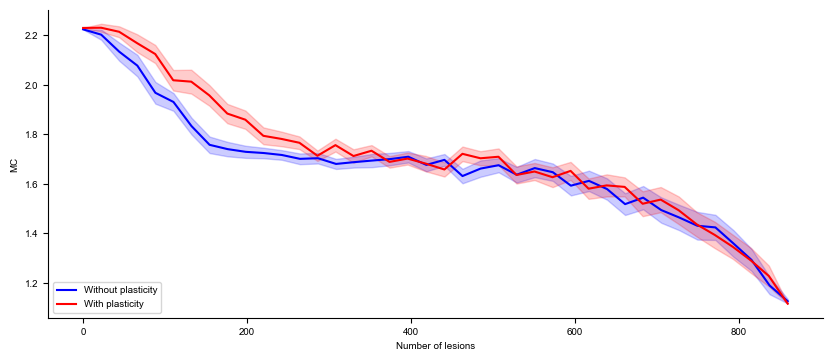

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(np.unique(no_plasticity.n_lesions.values), mean_np, color='blue', label = "Without plasticity")
plt.fill_between(np.unique(no_plasticity.n_lesions.values), mean_np + 1.96 * se_np, mean_np - 1.96 * se_np, color='blue', alpha=0.2)
plt.plot(np.unique(plasticity.n_lesions.values), mean_p, color='red', label = "With plasticity")
plt.fill_between(np.unique(plasticity.n_lesions.values), mean_p + 1.96 * se_p, mean_p - 1.96 * se_p, color='red', alpha=0.2)
plt.xlabel('Number of lesions')
plt.ylabel('MC')
plt.legend(loc="lower left")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Introducing delays into the network

Delays were added to the Conn2res toolbox by directly implementing the code of Iacob and Dambre (2024).

### A changing memory profile

In [12]:
# Define constants
INPUT_GAIN = 1.0

# Define the task
TASK = tc.MemoryCapacity(n = 6000, tau = 50)
u_train, u_test, y_train, y_test = TASK.fetch_data(input_gain = INPUT_GAIN, train = 0.8)

# Get the coordinates
COORDS = np.load("data/human/coords.npy")

In [13]:
# Load the connectome
w = np.load("data/human/consensus_0.npy")
conn = Conn(w=w)
conn.scale_and_normalize()

# Get the input and output nodes
input_nodes = [501, 1007] # thalamic
output_nodes = conn.get_nodes(nodes_from = None, node_set = 'VIS')

# Build the input matrix
w_in = np.zeros((1, conn.n_nodes))
w_in[:, input_nodes] = np.eye(1)

In [14]:
def run_delay(dtv, alpha):
    readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=50)
    
    esn = RC.ESNLesion(w=conn.w, targets=np.repeat(0.0, conn.w.shape[0]), activation_function="tanh", delay=True, dtv=dtv, coords=COORDS)
    esn.w = alpha * conn.w

    print("The distances in the matrix follow a normal distribution: ")
    plt.hist(esn.D.flatten(), bins=100)
    plt.xlabel("Inter-node distance")
    plt.ylabel("Number of occurrences")
    plt.title("Histogram of the discrete distances")
    plt.show()

    rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
    rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

    MC_train, MC_test, e_train, e_test = readout_module.run_task(
        X=(rs_train, rs_test), y=(y_train, y_test)
    )

    return MC_test

In [15]:
def run(alpha):
    readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=50)
    
    esn = RC.ESNLesion(w=conn.w, targets=np.repeat(0.0, conn.w.shape[0]), activation_function="tanh")
    esn.w = alpha * conn.w

    rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
    rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

    MC_train, MC_test, e_train, e_test = readout_module.run_task(
        X=(rs_train, rs_test), y=(y_train, y_test)
    )

    return MC_test

29
The distances in the matrix follow a normal distribution: 


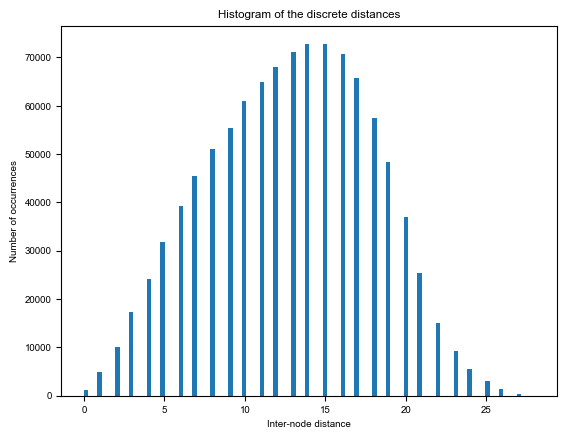

In [16]:
MC_delay = run_delay(6, 1.2)
MC = run(1.2)

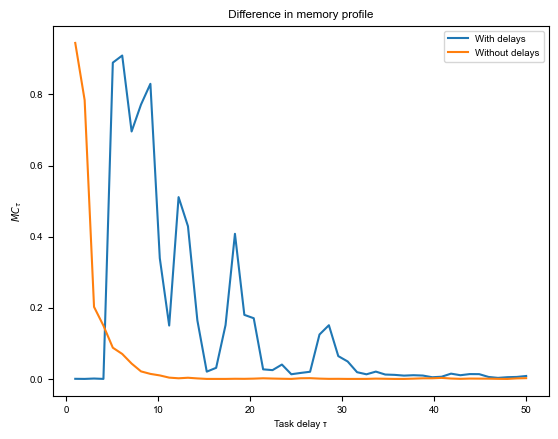

In [17]:
# Visualisation

plt.plot(np.linspace(1, 50, 49), MC_delay, label="With delays")
plt.plot(np.linspace(1, 50, 49), MC, label="Without delays")
plt.legend()
plt.xlabel('Task delay τ')
plt.ylabel("$MC_τ$")
plt.title(" Difference in memory profile ")
plt.show()

The memory capacity is stronger at very specific delays. Eventually it does die out. This effect was already described by Iacob et al. (2024).

### Resistance to lesions with and without plasticity

The smaller the $\Delta t \times v$ value, the larger the MC. However, as shown above, the memory capacity profile changes. Furthermore, the effect on lesions also changes. First we will look into the effect of adding a more refined delay into the network, then we will look into the effect of plasticity on this profile.

The experiment was run on the HPC using "robustness_to_lesions.py". The files are loaded into csv files.

In [18]:
dtv6 = pd.read_csv("objective1/df_thalamic_delay_dtv6.csv")
dtv6_plasticity = pd.read_csv("objective1/df_thalamic_delay_plasticity_dtv6.csv")
dtv60 = pd.read_csv("objective1/df_thalamic_delay_dtv60.csv")
dtv60_plasticity = pd.read_csv("objective1/df_thalamic_delay_plasticity_dtv60.csv")

Again, the mean and confidence interval of the mean are estimated by creating a bootstrap.

In [19]:
mean_dtv6 = []
se_dtv6 = []
for lesion in np.unique(dtv6.n_lesions.values):
    # Load sample
    MC_values = dtv6['MC'][dtv6.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_dtv6.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_dtv6.append(se)
mean_dtv6 = np.array(mean_dtv6)
se_dtv6 = np.array(se_dtv6)

In [20]:
mean_dtv6_p = []
se_dtv6_p = []
for lesion in np.unique(dtv6_plasticity.n_lesions.values):
    # Load sample
    MC_values = dtv6_plasticity['MC'][dtv6_plasticity.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_dtv6_p.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_dtv6_p.append(se)
mean_dtv6_p = np.array(mean_dtv6_p)
se_dtv6_p = np.array(se_dtv6_p)

In [21]:
mean_dtv60 = []
se_dtv60 = []
for lesion in np.unique(dtv60.n_lesions.values):
    # Load sample
    MC_values = dtv60['MC'][dtv60.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_dtv60.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_dtv60.append(se)
mean_dtv60 = np.array(mean_dtv60)
se_dtv60 = np.array(se_dtv60)

In [22]:
mean_dtv60_p = []
se_dtv60_p = []
for lesion in np.unique(dtv60_plasticity.n_lesions.values):
    # Load sample
    MC_values = dtv60_plasticity['MC'][dtv60_plasticity.n_lesions == lesion].values
    
    # Bootstrap 1000 times
    mean_bootstrap = []
    for i in range(1000):
        sample = np.random.choice(MC_values, size = 100, replace=True)
        mean_bootstrap.append(np.mean(sample))

    # Estimate of the mean and standard error of the mean
    mean_bootstrap = np.array(mean_bootstrap)
    mean = np.mean(mean_bootstrap) ; mean_dtv60_p.append(mean)
    se = np.sqrt(1 / (1000 - 1) * np.sum((mean_bootstrap - mean)**2)) ; se_dtv60_p.append(se)
mean_dtv60_p = np.array(mean_dtv60_p)
se_dtv60_p = np.array(se_dtv60_p)

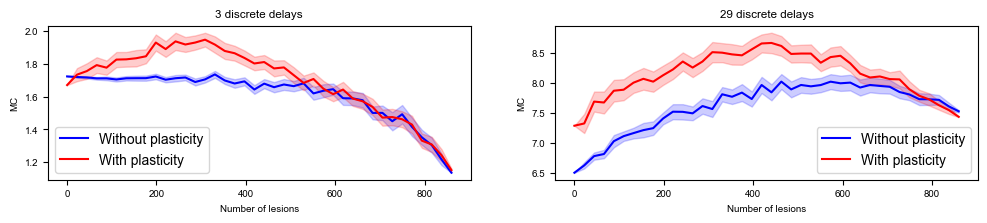

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (12, 2))
# dt x v = 6
axs[1].plot(np.unique(dtv6.n_lesions.values), mean_dtv6, color='blue', label = "Without plasticity")
axs[1].fill_between(np.unique(dtv6.n_lesions.values), mean_dtv6 + 1.96 * se_dtv6, mean_dtv6 - 1.96 * se_dtv6, color='blue', alpha=0.2)

# dt x v = 6, plasticity
axs[1].plot(np.unique(dtv6_plasticity.n_lesions.values), mean_dtv6_p, color='red', label = "With plasticity")
axs[1].fill_between(np.unique(dtv6_plasticity.n_lesions.values), mean_dtv6_p + 1.96 * se_dtv6_p, mean_dtv6_p - 1.96 * se_dtv6_p, color='red', alpha=0.2)

# dt x v = 60
axs[0].plot(np.unique(dtv60.n_lesions.values), mean_dtv60, color='blue', label = "Without plasticity")
axs[0].fill_between(np.unique(dtv60.n_lesions.values), mean_dtv60 + 1.96 * se_dtv60, mean_dtv60 - 1.96 * se_dtv60, color='blue', alpha=0.2)

axs[0].plot(np.unique(dtv60_plasticity.n_lesions.values), mean_dtv60_p, color='red', label = "With plasticity")
axs[0].fill_between(np.unique(dtv60_plasticity.n_lesions.values), mean_dtv60_p + 1.96 * se_dtv60_p, mean_dtv60_p - 1.96 * se_dtv60_p, color='red', alpha=0.2)

axs[0].set_xlabel('Number of lesions')
axs[0].set_ylabel('MC')
axs[0].set_title("3 discrete delays")
axs[0].legend(fontsize="10", loc='lower left')

axs[1].set_xlabel('Number of lesions')
axs[1].set_ylabel('MC')
axs[1].set_title("29 discrete delays")
axs[1].legend(fontsize="10")

plt.show()

It's interesting to see that if we increase the number of delays (or reduce the discrete distance of the connectome), the model performance increases by reducing the number of nodes.

The effect of plasticity also still holds. The plasticity increases the performance of the network. But, when the number of lesions is too large, plasticity can no longer compensate.

## References

[1] Falandays, J.B., Yoshimi, J., Warren, W.H. et al. A potential mechanism for Gibsonian resonance: behavioral entrainment emerges from local homeostasis in an unsupervised reservoir network. Cogn Neurodyn 18, 1811–1834 (2024). https://doi.org/10.1007/s11571-023-09988-2

[2] Iacob S, Dambre J. Exploiting Signal Propagation Delays to Match Task Memory Requirements in Reservoir Computing. Biomimetics (Basel). 2024 Jun 14;9(6):355. doi: 10.3390/biomimetics9060355. PMID: 38921237; PMCID: PMC11201534.

[3] Suárez, L.E., Mihalik, A., Milisav, F. et al. Connectome-based reservoir computing with the conn2res toolbox. Nat Commun 15, 656 (2024). https://doi.org/10.1038/s41467-024-44900-4